In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import yaml, glob, lmdb, json
import os, sys
import cv2
import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
test = {"a": 1, "b":2}
for i in test:
    print(i)

a
b


In [2]:
class DatasetToLMDB:
    def __init__(self, data_dir, config_path):
        self.data_dir = data_dir
        
        with open(config_path, 'r') as f:
            config = yaml.safe_load(f)
        self.camera_yaws = config['camera_yaws']
        
        # Ablation options
        self.multi_cam = config['multi_cam']
        self.total_image_size = 0
    
    def read_and_put_image(self, txn, image_path):
        image_name, extension = os.path.splitext(os.path.basename(image_path))
        with open(image_path, "rb") as img:
            img_np = np.fromfile(img, np.dtype('B'))
            txn.put(image_name.encode(), img_np)
        return sys.getsizeof(img_np)

    def read_and_put_label(self, txn, i, current_dir):
        lbl_paths = [os.path.join(current_dir, "rgbs", f"lbl_{d:02d}_{i:05d}.png") for d in range(0,12)]
        for path in lbl_paths:
            self.read_and_put_image(txn, path)
                     
    def put_data(self, txn, data, current_dir):
        """
        @param:
        txn - open transaction on lmdb
        data - dictionary containing location, rotation, speed and labels
        """
        n = data['len']
        txn.put('len'.encode(), str(n).encode())
        del data['len']
        

        for i in tqdm.tqdm(data, total=len(data)):
            value = data[i]
            i = int(i)
            for idx in range(len(self.camera_yaws)):
               # put images
                for cam, ext in [("wide","jpg"), ("narr", "jpg"), ("wide_sem","png"), ("narr_sem", "png")]:
                    self.total_image_size += self.read_and_put_image(txn, os.path.join(current_dir, "rgbs", f"{cam}_{idx}_{i:05d}.{ext}"))
               # put labels
                self.read_and_put_label(txn, i, current_dir)
            txn.put(
                f'loc_{i:05d}'.encode(),
                np.ascontiguousarray(value['loc']).astype(np.float32)
            )

            txn.put(
                f'rot_{i:05d}'.encode(),
                np.ascontiguousarray(value['rot']).astype(np.float32)
            )

            txn.put(
                f'spd_{i:05d}'.encode(),
                np.ascontiguousarray(value['spd']).astype(np.float32)
            )


            txn.put(
                f'cmd_{i:05d}'.encode(),
                np.ascontiguousarray(value['cmd']).astype(np.float32)
            )
        
    def dataset_to_lmdb(self):
        isdir = os.path.isdir(self.data_dir)

        for full_path in glob.glob(f'{self.data_dir}/**'):
            if not os.path.isdir(full_path):
                continue
            txn = lmdb.open(full_path, subdir=isdir,
                       map_size=1099511627776 * 2, readonly=False,
                       meminit=False, map_async=True).begin(write=True)
            with open(os.path.join(full_path, "data.json")) as file:
                data = json.load(file)
                self.put_data(txn, data, full_path)
            txn.commit()
        print("Images occupy: ", self.total_image_size)

In [7]:
dataset_to_lmdb = DatasetToLMDB("dataset", "WorldOnRails/config.yaml")
dataset_to_lmdb.dataset_to_lmdb()

100%|██████████| 195/195 [00:00<00:00, 256.23it/s]

Images occupy:  22693898


#### label image dimension

In [35]:
from PIL import Image
bl_image_path = "dataset/adyhsylssx/rgbs/lbl_03_00189.png"
image = np.asarray(Image.open(bl_image_path))

In [36]:
image.shape

(96, 96)

## Main dataset test

In [3]:
class MainDataset(Dataset):
    def __init__(self, data_dir, config_path):
            super().__init__()

            with open(config_path, 'r') as f:
                config = yaml.safe_load(f)

            self.T = config['num_plan']
            self.camera_yaws = config['camera_yaws']
            self.wide_crop_top = config['wide_crop_top']
            self.narr_crop_bottom = config['narr_crop_bottom']
            self.seg_channels = config['seg_channels']

            self.num_speeds = config['num_speeds']
            self.num_steers = config['num_steers']
            self.num_throts = config['num_throts']

            # Ablation options
            self.multi_cam = config['multi_cam']

            self.num_frames = 0
            self.txn_map = dict()
            self.idx_map = dict()
            self.yaw_map = dict()
            self.file_map = dict()

            # Load dataset
            for full_path in glob.glob(f'{data_dir}/**'):
                txn = lmdb.open(
                    full_path,
                    max_readers=1, readonly=True,
                    lock=False, readahead=False, meminit=False).begin(write=False)

                n = int(txn.get('len'.encode()))
                if n < self.T+1:
                    print (full_path, ' is too small. consider deleting it.')
                    txn.__exit__()
                else:
                    offset = self.num_frames
                    for i in range(n-self.T):
                        self.num_frames += 1
                        for j in range(len(self.camera_yaws)):
                            self.txn_map[(offset+i)*len(self.camera_yaws)+j] = txn
                            self.idx_map[(offset+i)*len(self.camera_yaws)+j] = i
                            self.yaw_map[(offset+i)*len(self.camera_yaws)+j] = j
                            self.file_map[(offset+i)*len(self.camera_yaws)+j] = full_path

            print(f'{data_dir}: {self.num_frames} frames (x{len(self.camera_yaws)})')

    def __len__(self):
        if self.multi_cam:
            return self.num_frames*len(self.camera_yaws)
        else:
            return self.num_frames
    
    def __getitem__(self, idx):

        if not self.multi_cam:
            idx *= len(self.camera_yaws)

        lmdb_txn = self.txn_map[idx]
        index = self.idx_map[idx]
        cam_index = self.yaw_map[idx]

        locs = self.__class__.access('loc', lmdb_txn, index, self.T+1, dtype=np.float32)
        rots = self.__class__.access('rot', lmdb_txn, index, self.T, dtype=np.float32)
        spds = self.__class__.access('spd', lmdb_txn, index, self.T, dtype=np.float32).flatten()
        
        decode = lambda x : cv2.imdecode(x, -1)
        lbls = np.stack([self.__class__.access(f'lbl_{d:02d}', lmdb_txn, index+1, self.T, dtype=np.uint8, preprocess=decode) for d in range(0,12)], axis=3)
        wide_rgb = self.__class__.access('wide_{}'.format(cam_index),  lmdb_txn, index, 1, dtype=np.uint8, preprocess=decode).reshape(240, 480, 3)
        wide_sem = self.__class__.access('wide_sem_{}'.format(cam_index),  lmdb_txn, index, 1, dtype=np.uint8, preprocess=decode).reshape(240,480, 3)
        narr_rgb = self.__class__.access('narr_{}'.format(cam_index),  lmdb_txn, index, 1, dtype=np.uint8, preprocess=decode).reshape(240,384,3)
        
        cmd = self.__class__.access('cmd', lmdb_txn, index, 1, dtype=np.float32).flatten()

        #wide_sem = filter_sem(wide_sem, self.seg_channels)

        # Crop cameras
        wide_rgb = wide_rgb[self.wide_crop_top:,:,::-1]
        wide_sem = wide_sem[self.wide_crop_top:]
        narr_rgb = narr_rgb[:-self.narr_crop_bottom,:,::-1]

        return wide_rgb, wide_sem, narr_rgb, lbls, locs, rots, spds, int(cmd)
    
    @staticmethod
    def access(tag, lmdb_txn, index, T, dtype=np.float32, preprocess = (lambda x : x)):
        return np.stack([preprocess(np.frombuffer(lmdb_txn.get((f'{tag}_{t:05d}').encode()), dtype)) for t in range(index,index+T)])

In [4]:
dataset = MainDataset("dataset", "WorldOnRails/config.yaml")

dataset: 195 frames (x3)


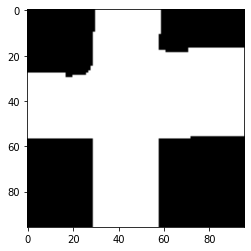

In [21]:
plt.imshow(dataset[0][3][0,:,:,0], cmap='gray')

In [7]:
dataset[0][3][.shape

(5, 96, 96, 12)